# 나의 첫번째 캐글 경진대회, 무작정 따라해보기 [프로젝트]
### - 기초다지기 rs9

* 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

* data path 저장

In [2]:
train_data_path = join('../aiffel/data/data', 'train.csv')
sub_data_path = join('../aiffel/data/data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']

del data['price']

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

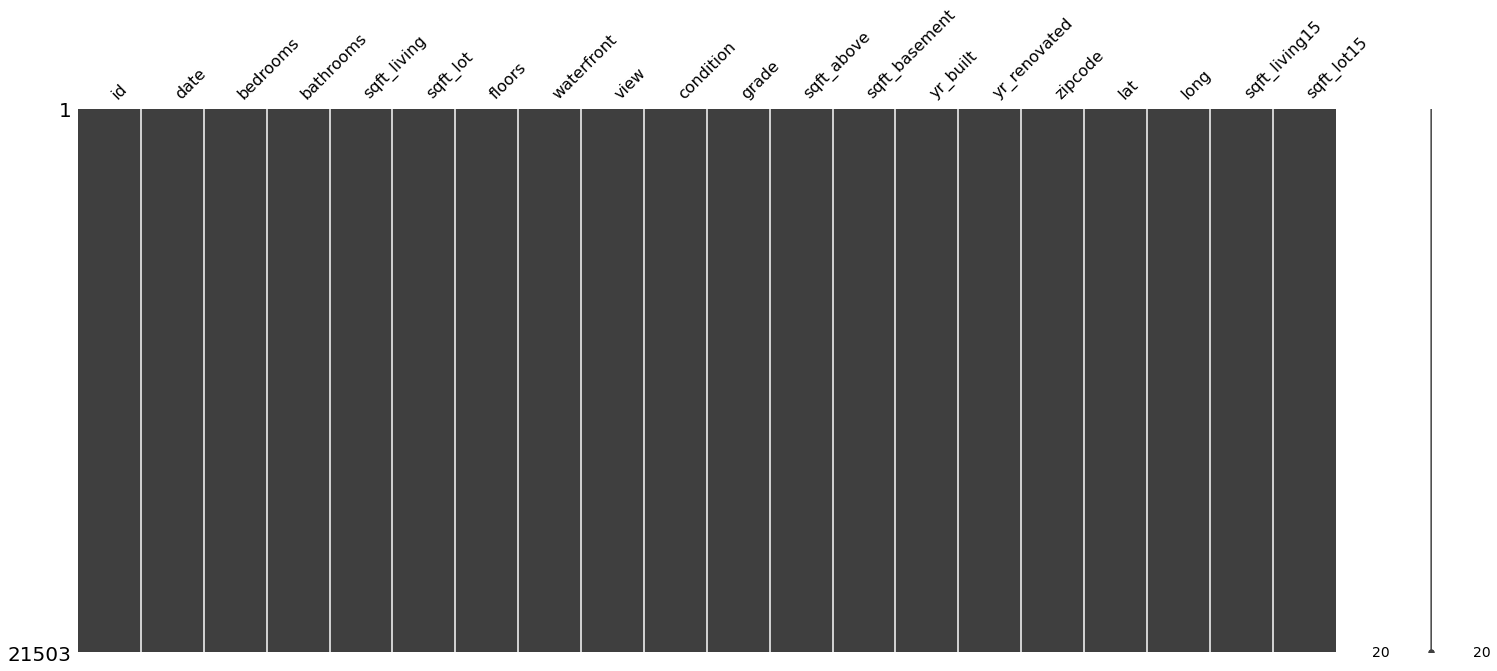

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [9]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

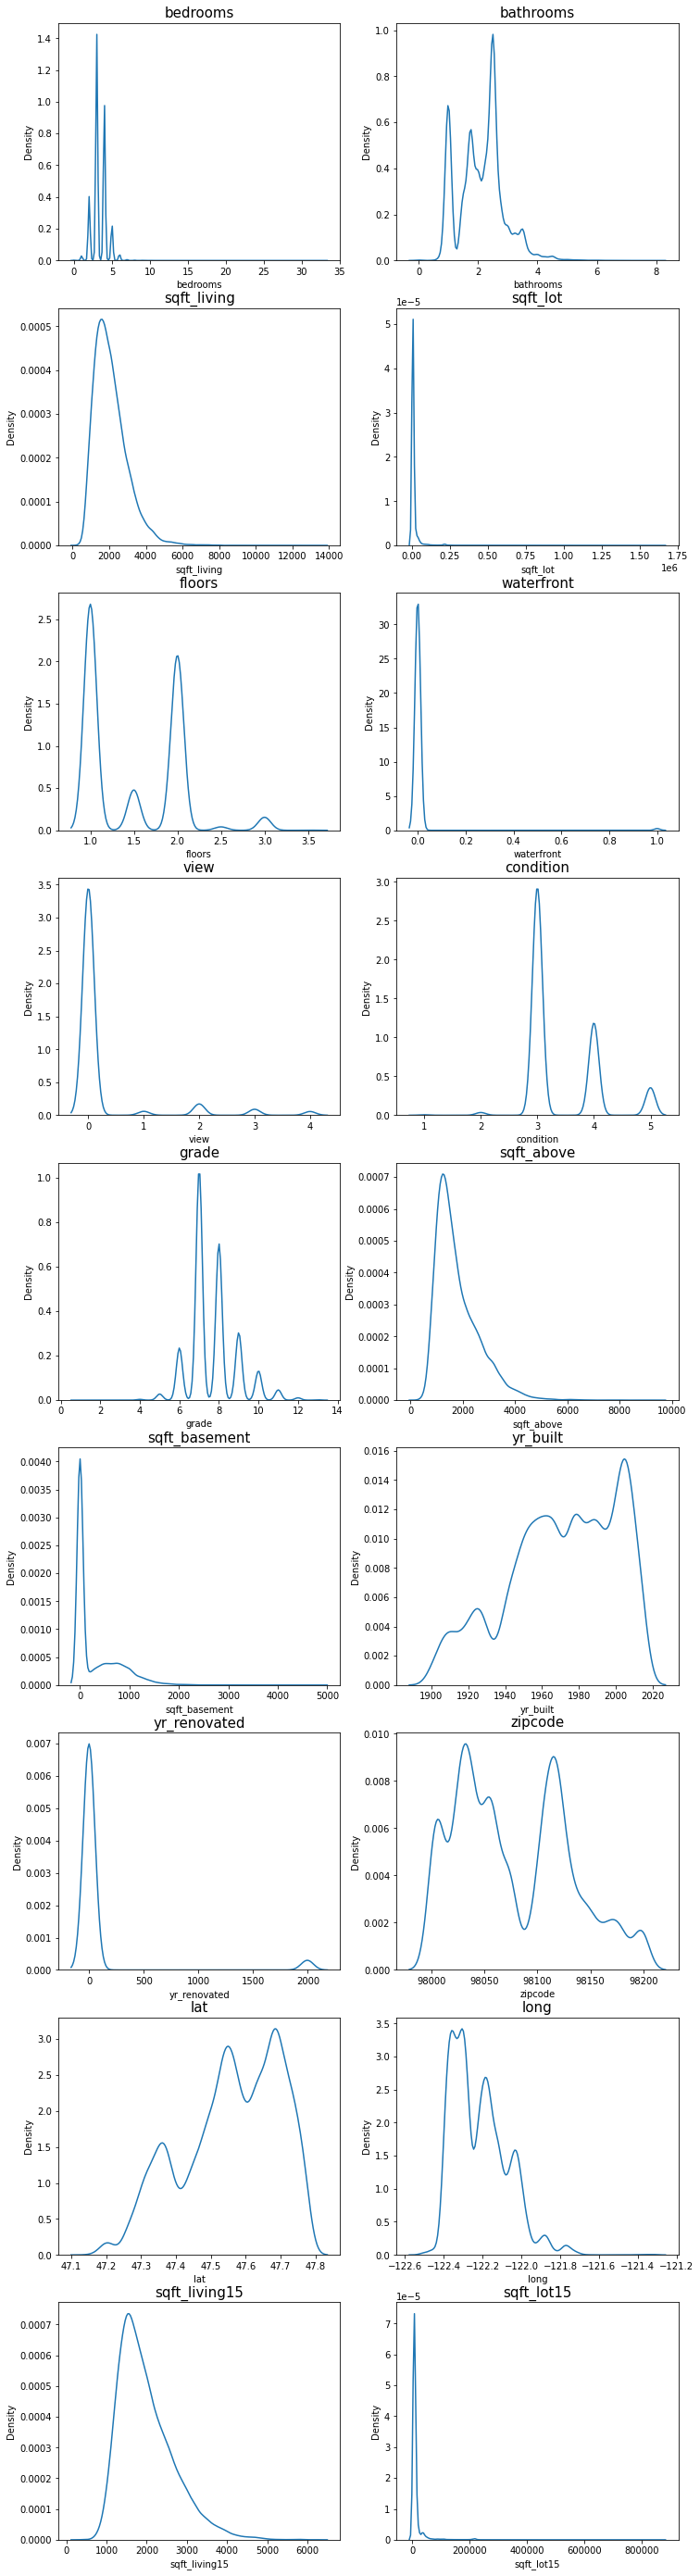

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

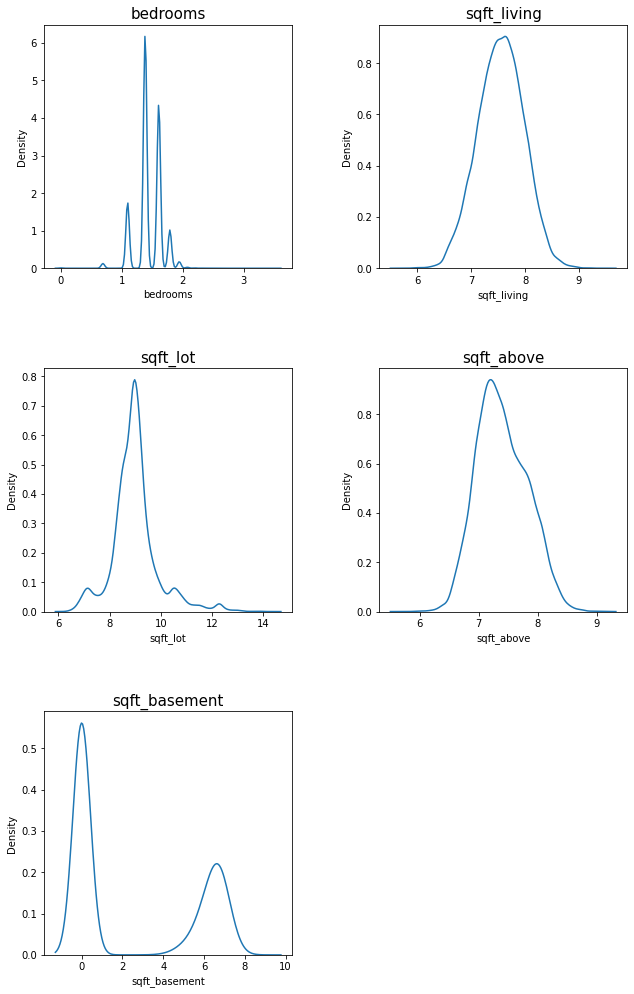

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# 데이터 인덱스 재설정
data = data.reset_index(drop=True)

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

# 서브플롯 생성
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count < len(skew_columns):
            sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
            ax[row][col].set_title(skew_columns[count], fontsize=15)
            count += 1

# 빈 서브플롯 제거 및 레이아웃 조정
fig.delaxes(ax[2][1])  # 빈 서브플롯 제거
fig.tight_layout(pad=5.0)  # 서브플롯 간의 간격 조정
plt.show()


어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [12]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [23]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

param_grids = {
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50],
        'subsample': [0.8, 1.0],
    }
}

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

- Random search 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

tuned_models = []

for model_info in models:
    model_name = model_info['name']
    model = model_info['model']
    
    randomized_search = RandomizedSearchCV(estimator=model, 
                                           param_distributions=param_grids[model_name],
                                           n_iter=2,  
                                           scoring='neg_mean_squared_error',
                                           cv=5,
                                           verbose=1,
                                           n_jobs=-1,
                                           random_state=2019)
    
    randomized_search.fit(x.values, y)
    
    print(f"Best params for {model_name}: {randomized_search.best_params_}")
    print(f"Best CV score for {model_name}: {-randomized_search.best_score_:.4f}")
    
    tuned_models.append({'model': randomized_search.best_estimator_, 'name': model_name})


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params for GradientBoosting: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
Best CV score for GradientBoosting: 22595665051.4395
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


* 시간 부족으로 Grid Search로 best parameter 테스트는 진행하지 못함

In [24]:
from sklearn.model_selection import GridSearchCV


tuned_models = []

for model_info in models:
    model_name = model_info['name']
    model = model_info['model']
    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grids[model_name],
                               scoring='neg_mean_squared_error',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)
    
    grid_search.fit(x.values, y)
    
    print(f"Best params for {model_name}: {grid_search.best_params_}")
    print(f"Best CV score for {model_name}: {-grid_search.best_score_:.4f}")
    
    tuned_models.append({'model': grid_search.best_estimator_, 'name': model_name})



Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [25]:
from sklearn.model_selection import KFold, cross_val_score

def get_cv_score_rmRand(models):
    kfold = KFold(n_splits=5)  # random_state 제거
    for m in models:
        score = cross_val_score(m['model'], x.values, y, cv=kfold)
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(score)))

# 예시 모델 리스트로 호출
get_cv_score_rmRand(models)


KeyboardInterrupt: 

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)

In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
sub.to_csv('submission5.csv', index=False)

## submission board

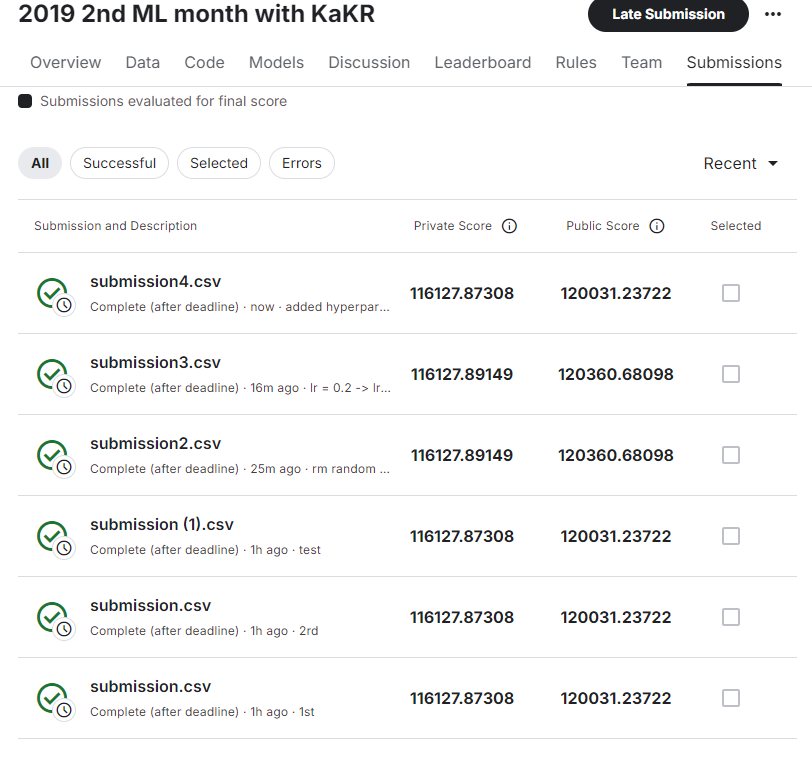